# Figure 1

## Multi-engine rescoring pipeline results (no quantification!).
### This workflow uses MSFragger Comet, Sage, PEAKS Studio 12.5 with follow-up TIMS2Rescore rescoring (Willems et al. 2025, JPR). In case of DDA data, the generated MSFragger calibrated mzML are used. In case of DIA data, pseudo-MS/MS files generated by diaTracer were used for this pipeline. Compared to the previous published analysis of this data, PEAKS Studio 12.5 was now used instead of PEAKS Studio 12.0. The generated peptides.txt read in here combines the aggregated results of all four rescored search engine results at a mokapot peptide 1% Q-value.

In [1]:
import pandas as pd

# ddaPASEF pipeline results
df = pd.read_csv('pipeline_ddaPASEF_peptides.txt',sep='\t')
pipelineDDA_peps = set(df['peptide'].unique())

# diaPASEF pipeline results
df = pd.read_csv('pipeline_diaPASEF_peptides.txt',sep='\t')
pipelineDIA_peps = set(df['peptide'].unique())

## Spectronaut 19 directDIA search.
### Regular directDIA search was ran on the 8 diaPASEF runs, searching for peptides of 7-20 AA long, variable methionine oxidation and N-terminal protein acetylation (max 1 mod per peptide). Protein FDR was set at 100% for identification and quantification as immunopeptidomics operates at peptide FDR level. A default peptide report was exported, adding the PEP.StrippedSequence and additional protein information columns. 

Median log2 intensity per run:
R.FileName
T064137_AurEl8_PM8_DIAIMP_CMB-1719_helalis_1_RD2_1_11076    7.214455
T064139_AurEl8_PM8_DIAIMP_CMB-1719_helalis_2_RD3_1_11078    7.383914
T064141_AurEl8_PM8_DIAIMP_CMB-1719_helalis_3_RD4_1_11080    7.290997
T064143_AurEl8_PM8_DIAIMP_CMB-1719_helalis_4_RD5_1_11082    7.194672
T064145_AurEl8_PM8_DIAIMP_CMB-1719_hela_1_RD6_1_11084       7.271468
T064147_AurEl8_PM8_DIAIMP_CMB-1719_hela_2_RD7_1_11086       7.228204
T064149_AurEl8_PM8_DIAIMP_CMB-1719_hela_3_RD8_1_11088       7.279100
T064151_AurEl8_PM8_DIAIMP_CMB-1719_hela_4_RE1_1_11090       7.275160
Name: log2_int, dtype: float64


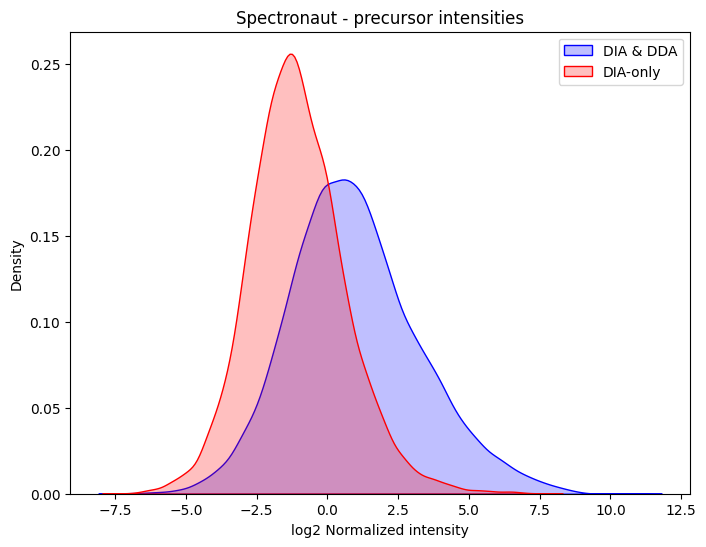

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na") # Seaborn kdeplot spam.

# Read Spectronaut report and get unique peptide sequences identified.
df = pd.read_csv('20250329_133719_T064137_proteinFDR_1_Report.tsv',sep='\t',decimal=',')
spectronaut_peps = set(df['PEP.StrippedSequence'].unique())

# Peptide found in DDA or not
df['dda'] = df['PEP.StrippedSequence'].isin(pipelineDDA_peps)

# Log2 transform and median normalize per run the intensities ("EG.TotalQuantity (Settings)").
df["log2_int"] = np.log2(df["EG.TotalQuantity (Settings)"]) # Log2 transform.
medians = df.groupby('R.FileName')['log2_int'].median() # Medians per run.
print(f'Median log2 intensity per run:\n{medians}')
df['log2_int_norm'] = df['log2_int'] - df['R.FileName'].map(medians) # Subtract median.
df.to_csv('Spectronaut_parsed.tsv',sep='\t') # Save values.

# Density plot of DIA-only peptides and those also found by ddaPASEF.
plt.figure(figsize=(8, 6))
sns.kdeplot(df[df["dda"] == True]["log2_int_norm"], fill=True, label="DIA & DDA", color="blue")
sns.kdeplot(df[df["dda"] == False]["log2_int_norm"], fill=True, label="DIA-only", color="red")
plt.xlabel("log2 Normalized intensity")
plt.ylabel("Density")
plt.title("Spectronaut - precursor intensities")
plt.legend()
plt.savefig('Spectronaut_dia_dda_int.svg')
plt.savefig('Spectronaut_dia_dda_int.png',dpi=600)
plt.show()
plt.clf()
plt.close()

## FragPipe with DIA-NN 2.0.2
### diaTracer was ran and pseudo-MS/MS were searched with MSFragger, searching for peptides of 7-20 AA long, variable methionine oxidation and N-terminal protein acetylation (max 1 mod per peptide). MSBooster was used for re-scoring and easypqp for spectral library building. Protein FDR is by default set at 100% in the HLA-immunopeptidome workflows. A first pass search was performed with DIA-NN v2.0.2 using the library.tsv in generic scoring mode for quantification. The parquet report is read in here.

Median log2 intensity per run:
Run
T064137_AurEl8_PM8_DIAIMP_CMB-1719_helalis_1_RD2_1_11076    15.373256
T064139_AurEl8_PM8_DIAIMP_CMB-1719_helalis_2_RD3_1_11078    14.814143
T064141_AurEl8_PM8_DIAIMP_CMB-1719_helalis_3_RD4_1_11080    14.878259
T064143_AurEl8_PM8_DIAIMP_CMB-1719_helalis_4_RD5_1_11082    14.852589
T064145_AurEl8_PM8_DIAIMP_CMB-1719_hela_1_RD6_1_11084       14.859241
T064147_AurEl8_PM8_DIAIMP_CMB-1719_hela_2_RD7_1_11086       14.844123
T064149_AurEl8_PM8_DIAIMP_CMB-1719_hela_3_RD8_1_11088       14.782983
T064151_AurEl8_PM8_DIAIMP_CMB-1719_hela_4_RE1_1_11090       14.647585
Name: log2_int, dtype: float32


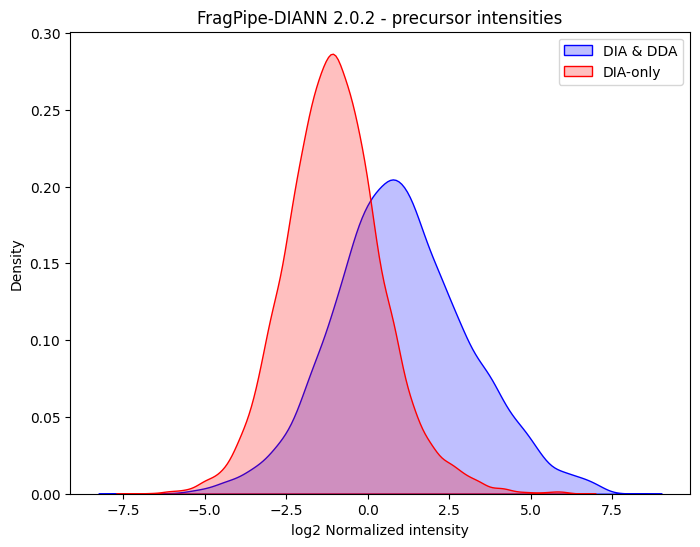

In [3]:
import pandas as pd
from Bio import SeqIO
from tqdm import tqdm
import sys

df = pd.read_parquet('fragpipe_diann_report.parquet')
df = df[df['Lib.Q.Value'] <= 0.01]
fragpipe_peps = set(df["Stripped.Sequence"].unique())

# Peptide found in DDA or not
df['dda'] = df['Stripped.Sequence'].isin(pipelineDDA_peps)

# Log2 transform and median normalize per run the intensities ("EG.TotalQuantity (Settings)").
df["log2_int"] = np.log2(df["Precursor.Normalised"]) # Log2 transform.
medians = df.groupby('Run')['log2_int'].median() # Medians per run.
print(f'Median log2 intensity per run:\n{medians}')
df['log2_int_norm'] = df['log2_int'] - df['Run'].map(medians) # Subtract median.
df.to_csv('FragPipe_DIANN202_parsed.tsv',sep='\t') # Save values.

# Density plot of DIA-only peptides and those also found by ddaPASEF.
plt.figure(figsize=(8, 6))
sns.kdeplot(df[df["dda"] == True]["log2_int_norm"], fill=True, label="DIA & DDA", color="blue")
sns.kdeplot(df[df["dda"] == False]["log2_int_norm"], fill=True, label="DIA-only", color="red")
plt.xlabel("log2 Normalized intensity")
plt.ylabel("Density")
plt.title("FragPipe-DIANN 2.0.2 - precursor intensities")
plt.legend()
plt.savefig('FragPipe_DIANN202_dia_dda_int.svg')
plt.savefig('FragPipe_DIANN202_dia_dda_int.png',dpi=600)
plt.show()
plt.clf()
plt.close()

# OVERLAP SPECTRUM CENTRIC

FragPipe: 5985 peptides
Spectronaut: 5963 peptides
Pipeline ddaPASEF: 7032 peptides
Pipeline diaPASEF: 8078 peptides


C:\Users\Installer\AppData\Roaming\Python\Python311\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
C:\Users\Installer\AppData\Roaming\Python\Python311\site-packages\upsetplot\plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are se

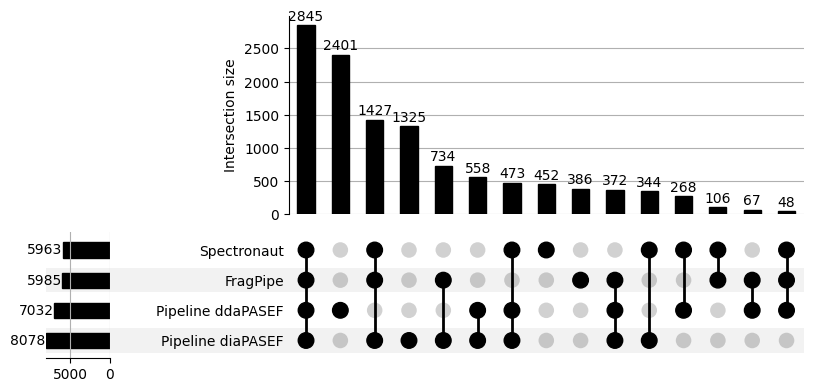

In [4]:
import pandas as pd
from upsetplot import UpSet, from_indicators
import matplotlib.pyplot as plt

# Ensure the peptide lists are sets
print(f'FragPipe: {len(fragpipe_peps)} peptides')
print(f'Spectronaut: {len(spectronaut_peps)} peptides')
print(f'Pipeline ddaPASEF: {len(pipelineDDA_peps)} peptides')
print(f'Pipeline diaPASEF: {len(pipelineDIA_peps)} peptides')

# Get all unique peptides
all_peptides = fragpipe_peps.union(spectronaut_peps, pipelineDDA_peps, pipelineDIA_peps)

# Create dataframe for upset plot.
data = pd.DataFrame({
    "FragPipe": [pep in fragpipe_peps for pep in all_peptides],
    "Spectronaut": [pep in spectronaut_peps for pep in all_peptides],
    "Pipeline diaPASEF": [pep in pipelineDIA_peps for pep in all_peptides],
    "Pipeline ddaPASEF": [pep in pipelineDDA_peps for pep in all_peptides]
}, index=list(all_peptides))  # Use peptides as row index

# Convert to UpSet-compatible format
upset_data = from_indicators(["FragPipe", "Spectronaut","Pipeline ddaPASEF","Pipeline diaPASEF"], data)

# Plot UpSet diagram
UpSet(upset_data,show_counts=True, sort_by="cardinality").plot()
plt.savefig('upset_spectrumCentric.svg')
plt.savefig('upset_spectrumCentric.png',dpi=600)
data.to_csv('upset_spectrumCentric.tsv',sep='\t')
plt.show()